## Neural Collaborative Filtering (NCF)
NCF is new neural matrix factorization model, which ensembles Generalized Matrix Factorization (GMF) and Multi-Layer Perceptron (MLP) to unify the strengths of linearity of MF and non-linearity of MLP for modelling the user–item latent structures. NCF can be demonstrated as a framework for GMF and MLP, which is illustrated as below:
<img src="https://recodatasets.blob.core.windows.net/images/NCF.svg?sanitize=true">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.externals import joblib 
import joblib
import tensorflow as tf
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.text import *
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image

C:\Users\hyoun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Read Data

In [2]:
# Data Columns
USER, ITEM, RATING = '회원번호', 'ISBN', '평점'

In [3]:
# positive sample과 이보다 3배 많은 negative sample 읽기
train, test = joblib.load('recsys_train_test_1v3.pkl')
train = train[train.ISBN.apply(lambda x: x[-1] not in ['X', 'x'])]
test = test[test.ISBN.apply(lambda x: x[-1] not in ['X', 'x'])]
train.ISBN = train.ISBN.astype(np.int64)
test.ISBN = test.ISBN.astype(np.int64)
train = train.query('평점 == 1 or (평점 == 0 and ISBN % 3 == 0)')

In [4]:
train.head()

,회원번호,ISBN,평점
0,65260,9788989415954,1.0
2,65260,9788959761579,0.0
4,65260,9788994780375,1.0
7,65260,9791155360071,0.0
8,65260,9788959977109,1.0


#### Preprocess Data

In [5]:
# user_id와 item_id를 0 ~ (id갯수-1)로 바꿔서 embedding layer에 입력 => NN의 weight를 줄이기 위해
vocab_users = {}
num_users = 0
for i in np.hstack([train[USER], test[USER]]): 
    if vocab_users.get(i) != None:
        continue
    vocab_users[i] = num_users
    num_users += 1
    
vocab_items = {}
num_items = 0
for i in np.hstack([train[ITEM], test[ITEM]]):
    if vocab_items.get(i) != None:
        continue
    vocab_items[i] = num_items
    num_items += 1 
    
encoded_users = [vocab_users[i] for i in train[USER]]
encoded_items = [vocab_items[i] for i in train[ITEM]]    

#### Build NCF Model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 8)         212856      user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (E

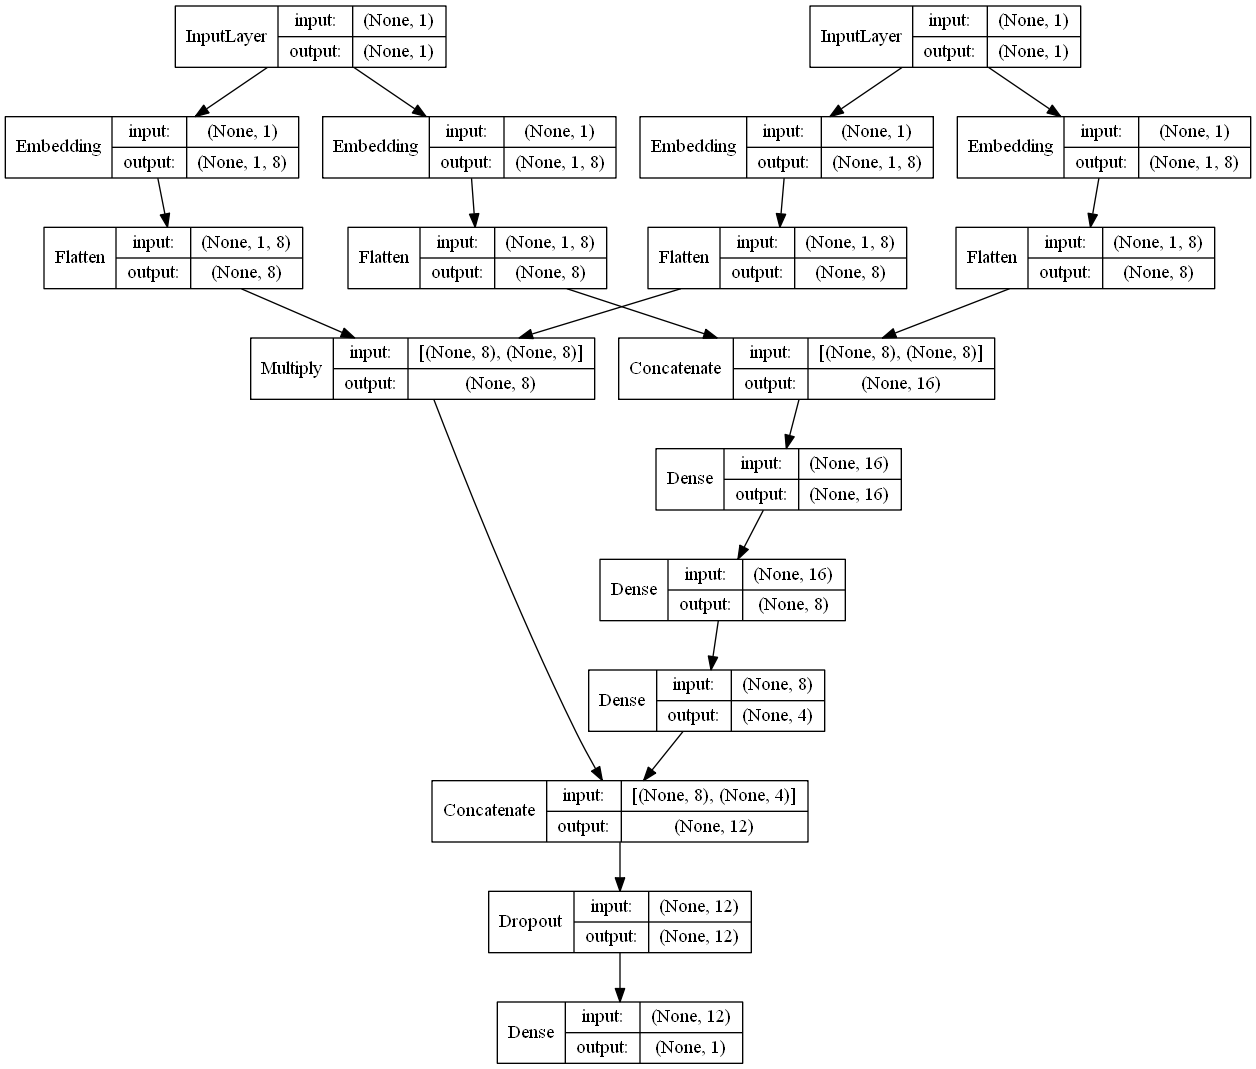

In [6]:
n_factors = 8  # 클수록 성능이 좋다고 함 ???
layers = [16, 8, 4]

# Input variables
user_input = Input(shape=(1,), dtype='int64', name = 'user_input')
item_input = Input(shape=(1,), dtype='int64', name = 'item_input')

# Embedding layer
MF_Embedding_User = Embedding(input_dim = num_users, output_dim = n_factors, 
                              name = 'mf_embedding_user', input_length=1)(user_input)
MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = n_factors,
                              name = 'mf_embedding_item', input_length=1)(item_input)   

MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0] // 2,
                               name = "mlp_embedding_user", input_length=1)(user_input)
MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0] // 2,
                               name = 'mlp_embedding_item', input_length=1)(item_input)   

# MF part
mf_user_latent = Flatten()(MF_Embedding_User)
mf_item_latent = Flatten()(MF_Embedding_Item)
mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

# MLP part 
mlp_user_latent = Flatten()(MLP_Embedding_User)
mlp_item_latent = Flatten()(MLP_Embedding_Item)
mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent])
# Layer 쌓는 층 
for idx in range(len(layers)):
    mlp_vector = Dense(layers[idx], activation='elu', name=f"layer{idx}")(mlp_vector)

# Concatenate MF and MLP parts
predict_vector = Concatenate()([mf_vector, mlp_vector])
predict_vector = Dropout(0.3)(predict_vector)

# Final prediction layer
prediction = Dense(1, activation='sigmoid', name = "prediction")(predict_vector)

model = Model([user_input, item_input], prediction)
model.compile(loss="binary_crossentropy", optimizer=RMSprop(lr=1e-3), metrics=["accuracy"])

model.summary()
Image(model_to_dot(model,show_shapes=True, show_layer_names=False).create(prog='dot', format='png'))

Instructions for updating:
Use tf.cast instead.
Train on 306427 samples, validate on 34048 samples
Epoch 1/10
 - 11s - loss: 0.5831 - acc: 0.6833 - val_loss: 0.4860 - val_acc: 0.7839
Epoch 2/10
 - 10s - loss: 0.4301 - acc: 0.8346 - val_loss: 0.4404 - val_acc: 0.8281
Epoch 3/10
 - 10s - loss: 0.3876 - acc: 0.8613 - val_loss: 0.4159 - val_acc: 0.8432
Epoch 4/10
 - 10s - loss: 0.3694 - acc: 0.8683 - val_loss: 0.4079 - val_acc: 0.8505
Epoch 5/10
 - 10s - loss: 0.3590 - acc: 0.8718 - val_loss: 0.4093 - val_acc: 0.8518
Epoch 6/10
 - 10s - loss: 0.3500 - acc: 0.8741 - val_loss: 0.4043 - val_acc: 0.8546
Epoch 7/10
 - 10s - loss: 0.3395 - acc: 0.8763 - val_loss: 0.4070 - val_acc: 0.8534
Epoch 8/10
 - 11s - loss: 0.3277 - acc: 0.8793 - val_loss: 0.4040 - val_acc: 0.8558
Epoch 9/10
 - 11s - loss: 0.3140 - acc: 0.8833 - val_loss: 0.4033 - val_acc: 0.8551
Epoch 10/10
 - 11s - loss: 0.2988 - acc: 0.8880 - val_loss: 0.4047 - val_acc: 0.8593


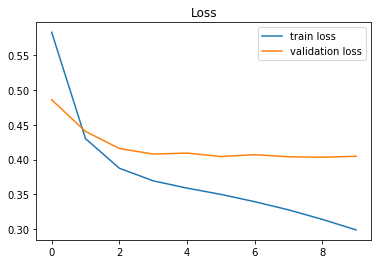

In [8]:
history = model.fit(x=[encoded_users, encoded_items], y=train[RATING], 
                    batch_size=256, epochs=10, validation_split=0.1, 
                    callbacks=[EarlyStopping(patience=3)], verbose=2)

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

#### Evaluate NCF Model

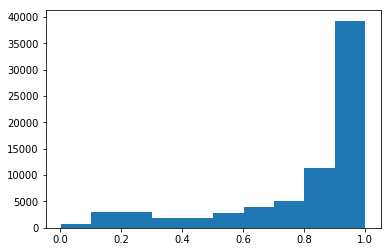

In [9]:
# 예측 rating(0~1) 빈도 도식화
plt.hist(model.predict([[vocab_users[i] for i in test[USER]], 
                        [vocab_items[i] for i in test[ITEM]]]))
plt.show()

In [10]:
# 정확도 측정
model.evaluate([[vocab_users[i] for i in test[USER]], [vocab_items[i] for i in test[ITEM]]],
               test[RATING])[1]

72825/72825 [==============================] - 5s 73us/step


0.8587298317795311

In [11]:
# 모형 저장
joblib.dump(model, 'ncf_model.pkl')

['ncf_model.pkl']

In [12]:
top_k = 10
test_users = 100

# 각 사용자별 추천 리스트 데이터 프레임 형식으로 출력
recs = []
prob = []
test_uid = np.sort(test[USER].unique()[:test_users])
for i, u in enumerate(test_uid):
    pred = model.predict([[vocab_users[u]]*len(vocab_items), range(len(vocab_items))]).flatten()
    rec = set([list(vocab_items.keys())[i] for i in np.argsort(-pred)[:top_k]])
    recs.append(rec)
    prob.append([i for i in np.sort(pred)[::-1][:top_k]])
    
recs = pd.DataFrame(pd.DataFrame(recs, index=test_uid).stack()).reset_index(). \
                    rename({'level_0':USER, 0: ITEM}, axis=1).iloc[:,[0,2]]
prob = pd.DataFrame(prob, index=test_uid).stack().reset_index().rename({0: 'score'}, axis=1).iloc[:,[2]]
recs_prob = pd.concat([recs, prob], axis=1)

recs_prob    

,회원번호,ISBN,score
0,2471,9788954730655,0.999651
1,2471,9788965744030,0.998990
2,2471,9788954730662,0.998828
3,2471,9788954730631,0.998416
4,2471,9788965744047,0.998399
5,2471,9788954730617,0.998299
6,2471,9788928310234,0.998264
7,2471,9788950952891,0.997869
8,2471,9788954730686,0.997608
9,2471,9788954730815,0.997584


In [13]:
from python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

# all ranking metrics have the same arguments
args = [test, recs_prob]
kwargs = dict(col_user=USER, 
              col_item=ITEM, 
              col_rating=RATING, 
              col_prediction='score', 
              relevancy_method='top_k', 
              k=10)

#eval_map = map_at_k(*args, **kwargs)
#eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

print(f"Model:",
      f"Top K:\t\t {10}",
#      f"MAP:\t\t {eval_map:f}",
#      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 10
Precision@K:	 0.014000
Recall@K:	 0.024358


## End